In [1]:
import sys; sys.path.insert(1, '../')
from utils import *
from pytorch_stats_loss import torch_wasserstein_loss, torch_energy_loss

import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from sklearn.datasets import make_circles
from scipy.stats import *

# for ploting only
%matplotlib inline
import matplotlib.pyplot as plt
import cufflinks as cf
import plotly.express as px
from plotly.offline import download_plotlyjs, init_notebook_mode
import plotly.graph_objects as go
init_notebook_mode(connected=True)
cf.go_offline()

# tracking
from tqdm import trange

In [2]:
def get_label(Xs): return multivariate_normal.pdf(Xs, mean=np.array([1.0, 0]), cov=np.eye(X.shape[1]))

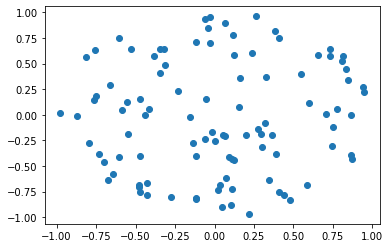

In [3]:
N = 2000
X = sampling_unit_circle(100)
y = get_label(X)
plt.scatter(X[:, 0], X[:, 1])
plt.show()

In [4]:
# fig = go.Figure(data=go.Contour(z=y, x=X[:, 0], y=X[:, 1]))
# fig.show()

In [5]:
# converting data to torch.tensor 
X = to_tensor(X, False)
y = to_tensor(y, False).reshape(-1, 1)

# setting the networks
solver = TorchMLP([2, 32, 32, 1])
generator = TorchMLP([2, 32, 32, 2])
solver_optimizer = torch.optim.Adam(solver.parameters(), lr=5e-3)
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=3e-4)

# training configs
epochs = 10000
lb, ub = -2, 2
adv_f = 100

In [6]:
for i in trange(0, epochs):
    if i%adv_f==0:
        # train generator
        print("Training the generator")
        for _ in range(2000):
            solver.eval()
            generator.train()
            solver_optimizer.zero_grad()
            generator_optimizer.zero_grad()
            X_gen = generator(X)
            X_gen = scale_to_range(X_gen, lb, ub)
            y_gen = to_tensor(get_label(to_numpy(X_gen)), False).reshape(-1, 1)
            distance_loss = torch_energy_loss(X_gen[:, 0], X[:, 0])+torch_energy_loss(X_gen[:, 1], X[:, 1])
            pred = solver(X_gen)
            adv_loss = -F.mse_loss(pred, y_gen)
            generator_loss = distance_loss+adv_loss
            generator_loss.backward(retain_graph=True)
            generator_optimizer.step()

    # train solver
    solver.train()
    generator.eval()
    solver_optimizer.zero_grad()
    generator_optimizer.zero_grad()
    X_train = torch.cat([X, X_gen], dim=0).detach()
    y_train = torch.cat([y, y_gen], dim=0).detach()
    pred = solver(X_train)
    solver_loss = F.mse_loss(pred, y_train)
    solver_loss.backward(retain_graph=True)
    solver_optimizer.step()
    
    if i%1000==0:
        print("Epoch:", str(i), solver_loss.item())
        print("Epoch:", str(i), generator_loss.item())

  0%|          | 0/10000 [00:00<?, ?it/s]

Training the generator


  0%|          | 1/10000 [00:03<10:37:52,  3.83s/it]

Epoch: 0 0.21747848391532898
Epoch: 0 0.08124518394470215
Training the generator


  1%|          | 101/10000 [00:07<7:23:56,  2.69s/it]

Training the generator


  2%|▏         | 201/10000 [00:11<5:09:33,  1.90s/it]

Training the generator


  3%|▎         | 301/10000 [00:15<3:36:23,  1.34s/it]

Training the generator


  4%|▍         | 401/10000 [00:18<2:31:29,  1.06it/s]

Training the generator


  5%|▌         | 501/10000 [00:21<1:46:24,  1.49it/s]

Training the generator


  6%|▌         | 601/10000 [00:25<1:15:15,  2.08it/s]

Training the generator


  7%|▋         | 701/10000 [00:28<53:35,  2.89it/s]  

Training the generator


  8%|▊         | 801/10000 [00:31<38:32,  3.98it/s]

Training the generator


  9%|▉         | 901/10000 [00:34<28:08,  5.39it/s]

Training the generator


 10%|█         | 1001/10000 [00:37<20:54,  7.17it/s]

Epoch: 1000 5.555007192015182e-06
Epoch: 1000 0.2261163890361786
Training the generator


 11%|█         | 1101/10000 [00:41<15:55,  9.31it/s]

Training the generator


 12%|█▏        | 1201/10000 [00:44<12:26, 11.78it/s]

Training the generator


 13%|█▎        | 1301/10000 [00:47<09:58, 14.54it/s]

Training the generator


 14%|█▍        | 1401/10000 [00:50<08:14, 17.38it/s]

Training the generator


 15%|█▌        | 1501/10000 [00:53<07:02, 20.14it/s]

Training the generator


 16%|█▌        | 1601/10000 [00:56<06:11, 22.58it/s]

Training the generator


 17%|█▋        | 1701/10000 [01:00<05:36, 24.65it/s]

Training the generator


 18%|█▊        | 1801/10000 [01:03<05:11, 26.34it/s]

Training the generator


 19%|█▉        | 1901/10000 [01:06<04:53, 27.62it/s]

Training the generator


 20%|██        | 2001/10000 [01:09<04:38, 28.70it/s]

Epoch: 2000 1.341169422630628e-06
Epoch: 2000 0.19248226284980774
Training the generator


 21%|██        | 2101/10000 [01:12<04:28, 29.43it/s]

Training the generator


 22%|██▏       | 2201/10000 [01:16<04:20, 29.94it/s]

Training the generator


 23%|██▎       | 2301/10000 [01:19<04:13, 30.34it/s]

Training the generator


 24%|██▍       | 2401/10000 [01:22<04:11, 30.23it/s]

Training the generator


 25%|██▌       | 2501/10000 [01:25<04:08, 30.18it/s]

Training the generator


 26%|██▌       | 2601/10000 [01:29<04:01, 30.63it/s]

Training the generator


 27%|██▋       | 2701/10000 [01:32<03:57, 30.73it/s]

Training the generator


 28%|██▊       | 2801/10000 [01:35<03:52, 31.00it/s]

Training the generator


 29%|██▉       | 2901/10000 [01:38<03:47, 31.24it/s]

Training the generator


 30%|███       | 3001/10000 [01:41<03:44, 31.20it/s]

Epoch: 3000 6.264075409490033e-07
Epoch: 3000 0.1328973025083542
Training the generator


 31%|███       | 3101/10000 [01:45<03:39, 31.40it/s]

Training the generator


 32%|███▏      | 3201/10000 [01:48<03:35, 31.53it/s]

Training the generator


 33%|███▎      | 3301/10000 [01:51<03:35, 31.02it/s]

Training the generator


 34%|███▍      | 3401/10000 [01:55<03:42, 29.59it/s]

Training the generator


 35%|███▌      | 3501/10000 [01:58<03:43, 29.14it/s]

Training the generator


 36%|███▌      | 3601/10000 [02:02<03:38, 29.29it/s]

Training the generator


 37%|███▋      | 3701/10000 [02:05<03:38, 28.86it/s]

Training the generator


 38%|███▊      | 3801/10000 [02:08<03:30, 29.49it/s]

Training the generator


 39%|███▉      | 3901/10000 [02:12<03:23, 29.97it/s]

Training the generator


 41%|████      | 4067/10000 [02:15<02:19, 42.66it/s]

Epoch: 4000 3.773714638555248e-07
Epoch: 4000 0.12023185193538666
Training the generator


 41%|████      | 4101/10000 [02:18<04:22, 22.50it/s]

Training the generator


 42%|████▏     | 4201/10000 [02:21<03:56, 24.51it/s]

Training the generator


 43%|████▎     | 4301/10000 [02:25<03:39, 25.99it/s]

Training the generator


 44%|████▍     | 4401/10000 [02:28<03:27, 26.94it/s]

Training the generator


 45%|████▌     | 4501/10000 [02:31<03:18, 27.74it/s]

Training the generator


 46%|████▌     | 4601/10000 [02:35<03:11, 28.22it/s]

Training the generator


 47%|████▋     | 4701/10000 [02:38<03:03, 28.80it/s]

Training the generator


 48%|████▊     | 4801/10000 [02:42<03:06, 27.89it/s]

Training the generator


 49%|████▉     | 4901/10000 [02:45<03:01, 28.14it/s]

Training the generator


 50%|█████     | 5001/10000 [02:49<02:55, 28.45it/s]

Epoch: 5000 2.185284574807156e-05
Epoch: 5000 0.2048342376947403
Training the generator


 51%|█████     | 5101/10000 [02:52<02:48, 29.07it/s]

Training the generator


 52%|█████▏    | 5201/10000 [02:55<02:43, 29.35it/s]

Training the generator


 53%|█████▎    | 5301/10000 [02:59<02:37, 29.81it/s]

Training the generator


 54%|█████▍    | 5401/10000 [03:02<02:33, 29.88it/s]

Training the generator


 55%|█████▌    | 5501/10000 [03:05<02:29, 30.11it/s]

Training the generator


 56%|█████▌    | 5601/10000 [03:09<02:25, 30.33it/s]

Training the generator


 57%|█████▋    | 5701/10000 [03:12<02:21, 30.48it/s]

Training the generator


 58%|█████▊    | 5801/10000 [03:15<02:16, 30.72it/s]

Training the generator


 59%|█████▉    | 5901/10000 [03:18<02:12, 31.01it/s]

Training the generator


 60%|██████    | 6001/10000 [03:21<02:07, 31.24it/s]

Epoch: 6000 1.1975027973676333e-06
Epoch: 6000 0.12047079205513
Training the generator


 61%|██████    | 6101/10000 [03:24<02:05, 31.17it/s]

Training the generator


 62%|██████▏   | 6201/10000 [03:28<02:02, 30.92it/s]

Training the generator


 63%|██████▎   | 6301/10000 [03:31<02:00, 30.77it/s]

Training the generator


 64%|██████▍   | 6401/10000 [03:34<01:57, 30.73it/s]

Training the generator


 65%|██████▌   | 6501/10000 [03:37<01:52, 31.02it/s]

Training the generator


 66%|██████▌   | 6601/10000 [03:41<01:50, 30.81it/s]

Training the generator


 67%|██████▋   | 6701/10000 [03:44<01:46, 31.02it/s]

Training the generator


 68%|██████▊   | 6801/10000 [03:47<01:42, 31.11it/s]

Training the generator


 69%|██████▉   | 6901/10000 [03:50<01:39, 31.21it/s]

Training the generator


 70%|███████   | 7001/10000 [03:54<01:35, 31.27it/s]

Epoch: 7000 5.618083491754078e-07
Epoch: 7000 0.11387335509061813
Training the generator


 71%|███████   | 7101/10000 [03:57<01:33, 31.03it/s]

Training the generator


 72%|███████▏  | 7201/10000 [04:00<01:33, 30.03it/s]

Training the generator


 73%|███████▎  | 7301/10000 [04:04<01:31, 29.45it/s]

Training the generator


 74%|███████▍  | 7401/10000 [04:07<01:29, 29.16it/s]

Training the generator


 75%|███████▌  | 7501/10000 [04:11<01:24, 29.67it/s]

Training the generator


 76%|███████▌  | 7601/10000 [04:14<01:19, 30.31it/s]

Training the generator


 77%|███████▋  | 7701/10000 [04:17<01:15, 30.55it/s]

Training the generator


 78%|███████▊  | 7801/10000 [04:20<01:11, 30.95it/s]

Training the generator


 79%|███████▉  | 7901/10000 [04:23<01:07, 31.09it/s]

Training the generator


 80%|████████  | 8001/10000 [04:27<01:04, 30.98it/s]

Epoch: 8000 2.579064926067076e-07
Epoch: 8000 0.1200660914182663
Training the generator


 81%|████████  | 8101/10000 [04:30<01:01, 30.81it/s]

Training the generator


 82%|████████▏ | 8201/10000 [04:34<01:01, 29.13it/s]

Training the generator


 83%|████████▎ | 8301/10000 [04:38<01:00, 28.18it/s]

Training the generator


 84%|████████▍ | 8401/10000 [04:41<00:55, 28.73it/s]

Training the generator


 85%|████████▌ | 8501/10000 [04:44<00:51, 29.08it/s]

Training the generator


 86%|████████▌ | 8601/10000 [04:47<00:47, 29.75it/s]

Training the generator


 87%|████████▋ | 8701/10000 [04:51<00:43, 30.05it/s]

Training the generator


 88%|████████▊ | 8801/10000 [04:54<00:40, 29.97it/s]

Training the generator


 89%|████████▉ | 8901/10000 [04:57<00:37, 29.64it/s]

Training the generator


 90%|█████████ | 9001/10000 [05:01<00:33, 29.69it/s]

Epoch: 9000 4.3691471773854573e-07
Epoch: 9000 0.1033506765961647
Training the generator


 91%|█████████ | 9101/10000 [05:04<00:30, 29.91it/s]

Training the generator


 92%|█████████▏| 9201/10000 [05:07<00:26, 30.22it/s]

Training the generator


 93%|█████████▎| 9301/10000 [05:10<00:22, 30.61it/s]

Training the generator


 94%|█████████▍| 9401/10000 [05:14<00:19, 30.94it/s]

Training the generator


 95%|█████████▌| 9501/10000 [05:17<00:16, 30.66it/s]

Training the generator


 96%|█████████▌| 9601/10000 [05:20<00:13, 30.35it/s]

Training the generator


 97%|█████████▋| 9701/10000 [05:24<00:09, 30.37it/s]

Training the generator


 98%|█████████▊| 9801/10000 [05:27<00:06, 30.68it/s]

Training the generator


100%|██████████| 10000/10000 [05:30<00:00, 30.23it/s]


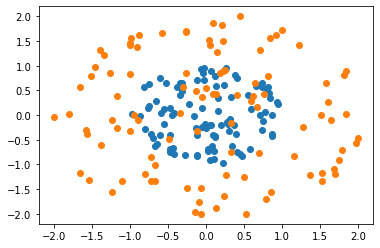

In [9]:
plt.scatter(to_numpy(X)[:, 0], to_numpy(X)[:, 1])
plt.scatter(to_numpy(X_gen)[:, 0], to_numpy(X_gen)[:, 1])
plt.show()